# Image Captioning Final Project

In this final project you will define and train an image-to-caption model, that can produce descriptions for real world images!

<img src="https://github.com/hse-aml/intro-to-dl-pytorch/blob/main/week06/images/encoder_decoder.png?raw=1" style="width:70%">

Model architecture: CNN encoder and RNN decoder.
(https://research.googleblog.com/2014/11/a-picture-is-worth-thousand-coherent.html)

Alright, here's our plan:
* Take a pre-trained inception v3 to vectorize images
* Stack an LSTM on top of it
* Train the thing on MSCOCO

## Importing stuff and preparing data

In [ ]:
%%bash

shred -u setup_colab.py

wget https://raw.githubusercontent.com/hse-aml/intro-to-dl-pytorch/main/utils/setup_colab.py -O setup_colab.py

shred: setup_colab.py: failed to open for writing: No such file or directory
--2021-04-18 15:23:52--  https://raw.githubusercontent.com/hse-aml/intro-to-dl-pytorch/main/utils/setup_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1649 (1.6K) [text/plain]
Saving to: ‘setup_colab.py’

     0K .                                                     100% 16.9M=0s

2021-04-18 15:23:53 (16.9 MB/s) - ‘setup_colab.py’ saved [1649/1649]



In [ ]:
import setup_colab

setup_colab.setup_week06()

In [ ]:
import grading
import grading_utils

grader = grading.Grader(
    assignment_key="NEDBg6CgEee8nQ6uE8a7OA",
    all_parts=["19Wpv", "E2OIL", "rbpnH", "YJR7z"]
)

In [ ]:
# token expires every 30 min
COURSERA_TOKEN = "CN65pKllln2MASje"
COURSERA_EMAIL = "y.zvorykina@gmail.com"

In [ ]:
%%time

# Load dataset (vectorized images and captions)
import numpy as np
import json

img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

In [ ]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

As you can see, all captions are already tokenized and lowercased. We now want to split them and add some special tokens for start/end of caption.

In [ ]:
# split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i]
        captions[img_i][caption_i] = ["#START#"] + sentence.split(' ') + ["#END#"]

You don't want your network to predict a million-size vector of probabilities at each step, so we're gotta make some cuts.

We want you to count the occurences of each word so that we can decide which words to keep in our vocabulary.

In [ ]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

from collections import Counter
word_counts = Counter()

for i in captions:
    for j in i:
        word_counts.update(j)
# Compute word frequencies for each word in captions. See code above for data structure

# YOUR CODE HERE

In [ ]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [ ]:
## GRADED PART, DO NOT CHANGE!
grader.set_answer("19Wpv", grading_utils.test_vocab(vocab))

In [ ]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

In [ ]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))

    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

In [ ]:
# Try it out on several descriptions of a random image
as_matrix(captions[1337])

## Building our neural network
As we mentioned earlier, we shall build an rnn "language-model" conditioned on vectors from the convolutional part.

<img src="https://github.com/yunjey/pytorch-tutorial/raw/master/tutorials/03-advanced/image_captioning/png/model.png" style="width:70%">

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

In [ ]:
class CaptionNet(nn.Module):

    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048,drop_prob=0.5):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super().__init__()

        # a layer that converts conv features to initial_h (h_0) and initial_c (c_0)
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        self.drop_prob = drop_prob

        # create embedding for input words. Use the parameters (e.g. emb_size).
        # YOUR CODE HERE
        #self.embed_size = emb_size
        #self.embed = nn.Embedding(self.embed_size, self.embed_size, padding_idx=0)

        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM.
        # In the latter case (nn.LSTM), make sure batch_first=True
        # YOUR CODE HERE
        #self.lstm = nn.LSTM(self.embed_size + self.encoder_dim, self.hidden_size, self.num_layers, batch_first=True)

        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        # YOUR CODE HERE
        #self.dropout = nn.Dropout(drop_prob)
        #self.fc = nn.Linear(n_hidden, len(self.chars))

        self.emb = nn.Embedding(n_tokens, emb_size)

        self.lstm = nn.LSTM(emb_size, lstm_units, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.logits = nn.Linear(lstm_units, n_tokens)


    def forward(self, image_vectors, captions_ix):
        """
        Apply the network in training mode.
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i].
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """

        self.lstm.flatten_parameters()

        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        captions_emb = self.emb(captions_ix)
        batch_size, caption_len, emb_size = captions_emb.size()
        caption_len = captions_emb.size()
        len_list = [caption_len for i in range(captions_emb.size()[0])]
        #input_seq = nn.utils.rnn.pack_padded_sequence(captions_emb, len_list, batch_first=True)
        lstm_out, _ = self.lstm(captions_emb, (initial_cell[None], initial_hid[None]))
        lstm_out = self.dropout(lstm_out)
        #lstm_out = lstm_out.data.view(caption_len, batch_size, -1).permute(1, 0, 2)
        #lstm_out = lstm_out.data.view(caption_len, batch_size, -1)
        #lstm_out = out.contiguous().view(-1, self.n_hidden)
        logits = self.logits(lstm_out)


        return logits
        # compute embeddings for captions_ix
        # YOUR CODE HERE

        # apply recurrent layer to captions_emb.
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        # YOUR CODE HERE


        #next_logp = F.log_softmax(next_logits, dim=-1)
        #p_next = F.softmax(logits_next / temperature, dim=-1).data.numpy()[0]

        # compute logits from lstm_out
        # YOUR CODE HERE


In [ ]:
network = CaptionNet(n_tokens)

In [ ]:
dummy_img_vec = torch.randn(len(captions[0]), 2048)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [ ]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i].
        padded with pad_ix
    :returns: crossentropy (neg llh) loss for next captions_ix given previous ones. Scalar float tensor
    """

    # captions for input - all except last because we don't know next token for last one.
    #captions_ix_inp = captions_ix[:, :-1].contiguous()
    #captions_ix_next = captions_ix[:, 1:].contiguous()

    # apply the network, get predictions for captions_ix_next
    #logits_for_next = network.forward(image_vectors, captions_ix_inp)

    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask!
    # Make sure that predicting next tokens after EOS do not contribute to loss
    # You can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.

    # YOUR CODE HERE
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    # captions_ix_inp = captions_ix[:, :-1].contiguous().to(DEVICE)
    captions_ix_next = captions_ix[:, 1:].contiguous()
    # captions_ix_next = captions_ix[:, :].contiguous().to(DEVICE)

    logits_for_next = network.forward(image_vectors, captions_ix_inp)
    # logits_for_next = F.tanh(logits_for_next)

    #loss = nn.CrossEntropyLoss(size_average=False).to(DEVICE)
    loss = nn.CrossEntropyLoss(size_average=False, ignore_index=pad_ix)
    mask = (captions_ix[:, 1:] != pad_ix).view(-1)
    # mask = (captions_ix[:, :] != pad_ix).view(-1)

    loss_res = loss(torch.reshape(logits_for_next, (-1, logits_for_next.size(2)))[mask],
                               torch.reshape(captions_ix_next, (-1,))[mask]) / image_vectors.size(0)


    return loss_res

In [ ]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert len(dummy_loss.shape) <= 1, 'loss must be scalar'
assert dummy_loss.data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
    'loss should depend differentiably on all neural network weights'

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [ ]:
## GRADED PART, DO NOT CHANGE!
grader.set_answer("rbpnH", grading_utils.test_network(network))

In [ ]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

## Batch generator

In [ ]:
from sklearn.model_selection import train_test_split

captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(
    img_codes, captions, test_size=0.1, random_state=42
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):

    # sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)

    # get images
    batch_images = img_codes[random_image_ix]

    # 5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]

    # pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))

    # convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)

    return torch.tensor(batch_images, dtype=torch.float32), \
        torch.tensor(batch_captions_ix, dtype=torch.int64)

In [ ]:
generate_batch(img_codes, captions, 3)

(tensor([[0.1025, 0.3020, 0.5067,  ..., 0.2803, 1.2415, 0.5011],
         [0.2921, 0.6143, 0.7425,  ..., 0.1803, 1.3983, 0.4193],
         [0.1764, 0.2872, 0.0972,  ..., 0.0392, 0.1451, 0.6389]]),
 tensor([[   1,   24,   57,   35,   24,  538,   78,  163,   24,  150, 2302, 4100,
           194,   12,    2],
         [   1,   24,   29,   94,   58,   24, 1266,   14,  182,   50,   24,    0,
             2,    3,    3],
         [   1,   24,   29, 2712,   24,  526,   14,  662,  183,   24,  712,   12,
             2,    3,    3]]))

In [ ]:
## GRADED PART, DO NOT CHANGE!
grader.set_answer("E2OIL", grading_utils.test_batch(generate_batch(img_codes, captions, 3)))

In [ ]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

## Train and validate loop

In [ ]:
from tqdm import tqdm_notebook
from IPython.display import clear_output

In [ ]:
DEVICE = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
network = CaptionNet(n_tokens).to(DEVICE)
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)
#optimizer = torch.optim.AdamW(network.parameters(), lr=1e-3)


batch_size = 128
#batch_size = 150
n_epochs = 300
#n_batches_per_epoch = 50
n_batches_per_epoch = 100
n_validation_batches = 50  # how many batches are used for validation after each epoch
#n_validation_batches = 5

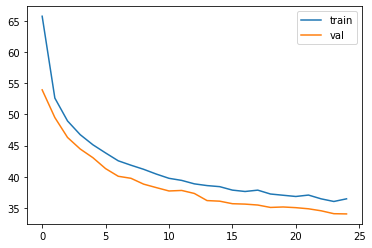

KeyboardInterrupt: ignored

In [ ]:


import matplotlib.pyplot as plt

history = []
history_val = []

clip = 0.5

for epoch in range(n_epochs):

    train_loss = 0
    network.train()

    for _ in tqdm_notebook(range(n_batches_per_epoch)):
        images, captions = generate_batch(train_img_codes, train_captions, batch_size)
        images = images.to(DEVICE)
        captions = captions.to(DEVICE)
        #h = network.init_hidden(batch_size)

        loss_t = compute_loss(network, images, captions)


        # clear old gradients; do a backward pass to get new gradients; then train with opt
        # YOUR CODE HERE
        #optimizer.zero_grad()

        network.zero_grad()
        loss_t.backward()
        nn.utils.clip_grad_norm_(network.parameters(), clip)
        optimizer.step()

        train_loss += loss_t.detach().cpu().numpy()

    train_loss /= n_batches_per_epoch

    val_loss = 0
    network.eval()
    for _ in range(n_validation_batches):
        images, captions = generate_batch(val_img_codes, val_captions, batch_size)
        images = images.to(DEVICE)
        captions = captions.to(DEVICE)

        with torch.no_grad():
            loss_t = compute_loss(network, images, captions)

        val_loss += loss_t.detach().cpu().numpy()

    val_loss /= n_validation_batches

    clear_output()
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    history.append(train_loss)
    history_val.append(val_loss)

    # display.clear_output()
    # fig, axes = plt.subplots(1, 3, figsize=(20, 7))

    if (epoch + 1) % 1 == 0:
        clear_output(True)
        plt.plot(history,label='train')
        plt.plot(history_val,label='val')
        plt.legend()
        plt.show()

print("Finished!")

In [ ]:


val_loss

30.339010772705077

In [ ]:
## GRADED PART, DO NOT CHANGE!
grader.set_answer("YJR7z", 3)

In [ ]:
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


## Generating caption

The function below creates captions by sampling from probabilities defined by the net.

The implementation used here is simple but inefficient (quadratic in lstm steps). We keep it that way since it isn't a performance bottleneck.

In [ ]:
from beheaded_inception3 import beheaded_inception_v3

inception = beheaded_inception_v3().eval()

def generate_caption(image, caption_prefix = ('#START#',), t=1, sample=True, max_len=100):
    network = network.cpu().eval()

    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >= 0 and image.shape[-1] == 3

    image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

    vectors_8x8, vectors_neck, logits = inception(image[None])
    caption_prefix = list(caption_prefix)

    for _ in range(max_len):

        prefix_ix = as_matrix([caption_prefix])
        prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
        next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
        next_word_probs = F.softmax(next_word_logits, -1).detach().numpy()

        assert len(next_word_probs.shape) == 1, 'probs must be one-dimensional'
        next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

        if sample:
            next_word = np.random.choice(vocab, p=next_word_probs)
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption_prefix.append(next_word)

        if next_word == '#END#':
            break

    return ' '.join(caption_prefix[1:-1])

In [ ]:
import matplotlib.pyplot as plt
from skimage.transform import resize

# sample image
! wget https://avatars.mds.yandex.net/get-zen_doc/1578906/pub_5deb7d24a06eaf00af983448_5deb7d6643863f00ae06dc24/scale_1200 -O data/img.jpg

In [ ]:
img = plt.imread('data/img.jpg')
img = resize(img, (299, 299))

plt.imshow(img)

for i in range(5):
    print(generate_caption(img, t=5.))

# Staff graded assignment tasks

Now you are going to train the network and estimate it's quality on checkpoints.

1. Train the network for 6 epoches (set n_batches_per_epoch to such value, that with batch_size you iterate over the whole dataset at one epoch, you should increase n_validation_batches to validate more accurately), find good and bad annotation examples. What loss values have you achieved?
1. Continue training until 12 epoch. What happened to the loss value? Search for examples, that have improved their captions in comparison to 6 epoch training.
1. Train the network until convergence. How many epoches do you need?
1. Mobile devices are not very powerfull. Try reducing network size (emb_size=64, lstm_units=128), how it affected network quality after 12 epoches in comparison to original network? And visually?
1. Collect at least 10 images that you like to test our network on.
    - Seriously, that's part of an assignment. Go get at least 10 pictures to get captioned
    - Make sure it works okay on simple images before going to something more complex
    - Photos, not animation/3d/drawings, unless you want to train CNN network on anime
    - Mind the aspect ratio
    - Photos should not be from MSCOCO! Collect some data yourself, take anything you find worth testing on

### Training tips

* If training loss has become close to 0 or model produces garbage, double-check that you're predicting next words, not current or t+2'th words
* If the model generates fluent captions that have nothing to do with the images
    * this may be due to recurrent net not receiving image vectors.
    * alternatively it may be caused by gradient explosion, try clipping 'em or just restarting the training
    * finally, you may just need to train the model a bit more
* Crossentropy is a poor measure of overfitting
    * Model can overfit validation crossentropy but keep improving validation quality.
    * Use human (manual) evaluation or try automated metrics: cider or bleu
    
* We recommend you to periodically evaluate the network using the next "apply trained model" block
    * its safe to interrupt training, run a few examples and start training again
* The typical loss values should be around 3~5 if you average over time, scale by length if you sum over time. The reasonable captions began appearing at loss=2.8 ~ 3.0

## Images to test on

We have downloaded 30 images from validation set of MSCOCO, they are located in `data` folder and named `img_i.jpg` for i from 0 to 29. You should use them to measure your network quality during checkpoints.

In [ ]:
### READ IMAGES FROM DISK

## First task

Train the network for 6 epoches (set n_batches_per_epoch to such value, that with batch_size you iterate over the whole dataset at one epoch, you should increase n_validation_batches to validate more accurately), find good and bad annotation examples. What loss values have you achieved?

In [ ]:
### USE CODE FROM ABOVE (MAIN TRAIN AND VAL LOOP)
### USE CODE FROM ABOVE (GENERATING CAPTION FOR IMAGES)

## Second task

Continue training until 12 epoch. What happened to the loss value? Search for examples, that have improved their captions in comparison to 6 epoch training.

In [ ]:
### USE CODE FROM ABOVE (MAIN TRAIN AND VAL LOOP)
### USE CODE FROM ABOVE (GENERATING CAPTION FOR IMAGES)

## Third task

Train the network until convergence. How many epoches do you need?

In [ ]:
### USE CODE FROM ABOVE (MAIN TRAIN AND VAL LOOP)

## Fourth task

 Mobile devices are not very powerfull. Try reducing network size (emb_size=64, lstm_units=128), how it affected network quality after 12 epoches in comparison to original network? And visually?

In [ ]:
### USE CODE FROM ABOVE (MAIN TRAIN AND VAL LOOP)
### USE CODE FROM ABOVE (GENERATING CAPTION FOR IMAGES)

## Fifth task

Collect at least 10 images that you like to test our network on.
   - Seriously, that's part of an assignment. Go get at least 10 pictures to get captioned
   - Make sure it works okay on simple images before going to something more complex
   - Photos, not animation/3d/drawings, unless you want to train CNN network on anime
   - Mind the aspect ratio
   - Photos should not be from MSCOCO! Collect some data yourself, take anything you find worth testing on

In [ ]:
### YOUR IMAGES COLLECTING CODE
### YOUR CAPTIONS GENERATING CODE